In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the path to the booktests directory is included (robust finder)
def _find_repo_root(start=os.getcwd()):
    cur = start
    while True:
        if os.path.exists(os.path.join(cur, 'pyproject.toml')):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            raise FileNotFoundError('repo root not found')
        cur = parent

sys.path.append(os.path.join(_find_repo_root(), 'test', 'booktests'))

# Configuration flags
force_compute = True
is_debug = False

# Create output directory if it doesn't exist
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

/tmp/ipykernel_38314/177490137.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


  workers   times  speedup
0       2  191.72     4.01
1       4  191.94     4.00
2       8  192.39     3.99
Saved plot to output/parallel_times_speedup.png


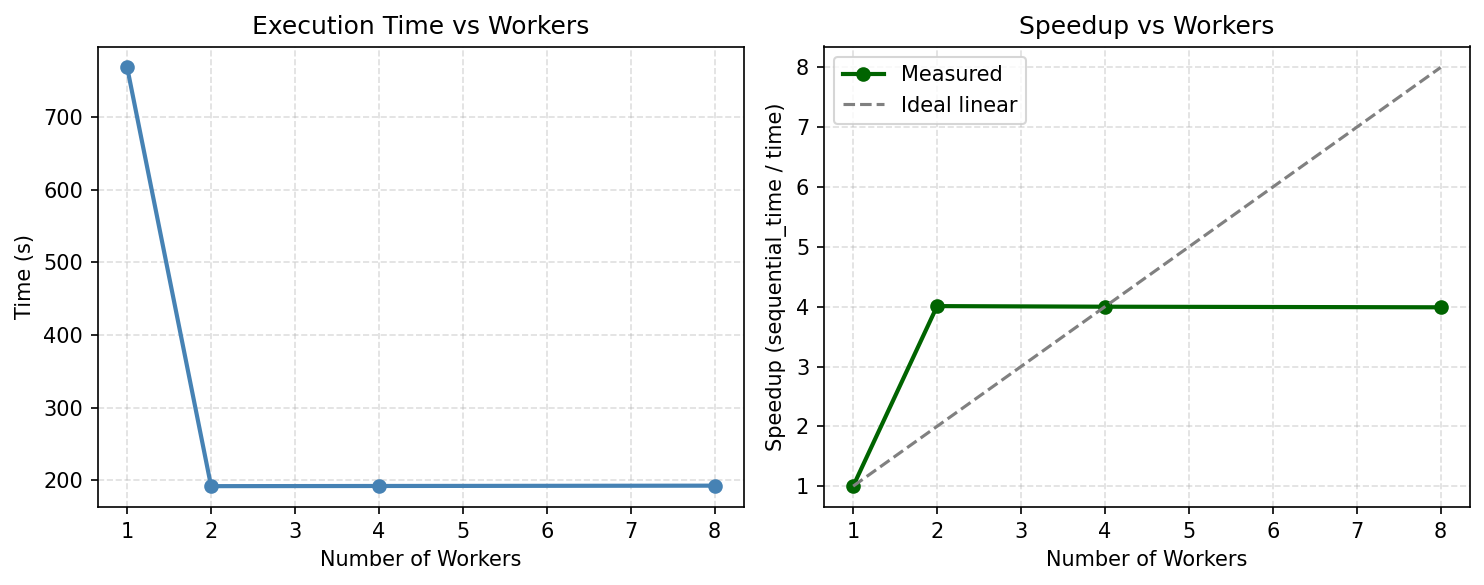

In [2]:
# read sequential time from file in output_dir
seq_fname = os.path.join(output_dir, "sequential_time.csv")
with open(seq_fname, "r") as f:
    sequential_time = float(f.read().strip())

df = pd.DataFrame(columns=["workers", "times", "speedup"])
for worker in [2, 4, 8]:
    fname  = f"parallel_times_{worker}.csv"
    # read CSV of parallel times if it exists
    df_tmp = pd.read_csv(output_dir+os.sep+fname)
            
    # Append df_tmp to df
    df = pd.concat([df, pd.DataFrame({
        "workers": df_tmp["workers"].values,
        "times": df_tmp["times"].values,
        "speedup": df_tmp["speedup"].values
    })], ignore_index=True)
    
print(df)

# Add [1, sequential_time, 1.0] to df
df = pd.concat([pd.DataFrame({
    "workers": [1],
    "times": [sequential_time],
    "speedup": [1.0]
}), df], ignore_index=True)

times = df["times"]
workers = df["workers"]
speedup = df["speedup"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Execution times
# Only plot if both workers and times arrays are non-empty and have the same length
if workers.size > 0 and times.size > 0 and workers.shape == times.shape:
    axes[0].plot(workers, times, marker="o", lw=2, color="steelblue")
else:
    axes[0].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
axes[0].set_xlabel("Number of Workers")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Execution Time vs Workers")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Speedup
# Only plot if both workers and speedup arrays are non-empty and have the same length
if workers.size > 0 and speedup.size > 0 and workers.shape == speedup.shape:
    axes[1].plot(workers, speedup, marker="o", lw=2, color="darkgreen", label="Measured")
else:
    axes[1].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
ideal = workers / workers[0]
axes[1].plot(workers, ideal, linestyle="--", color="gray", label="Ideal linear")
axes[1].set_xlabel("Number of Workers")
axes[1].set_ylabel("Speedup (sequential_time / time)")
axes[1].set_title("Speedup vs Workers")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
outname = os.path.join(output_dir, "parallel_times_speedup.png")
plt.savefig(outname, dpi=300, bbox_inches="tight")
print(f"Saved plot to {outname}")
plt.show()

In [3]:
!ls -ltr output/
!date

total 196
-rw-rw-rw- 1 codespace codespace      7 Dec  1 16:52 sequential_time.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  1 17:01 parallel_times_2.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  1 17:06 parallel_times_4.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  1 17:11 parallel_times_8.csv
-rw-rw-rw- 1 codespace codespace 183374 Dec  1 17:15 parallel_times_speedup.png
Mon Dec  1 17:15:04 UTC 2025
